# Notebook to fix the false positives in the KChip models

In [1]:
import pathlib
import pandas as pd

In [2]:
import warnings
import logging

warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.ERROR)

In [3]:
YIELD_TRESHOLD = 0.2
GROWTH_TRESHOLD = 0.01

## Identify the model-media combinations that result in false positives

### Get the experimental growth values

In [4]:
from kchip_utils import read_experimental_yield

In [5]:
met_profile_file = pathlib.Path("../../data/raw/kchip/media/metabolic_profiles.csv")
exp_yield = read_experimental_yield(met_profile_file)
exp_yield_binary = exp_yield.map(lambda x: 1 if x > YIELD_TRESHOLD else 0).astype(int)

In [6]:
true_positives = {row_label: exp_yield_binary.columns[row == 1].to_list() for row_label, row in exp_yield_binary.iterrows()}

### Load models and media

In [7]:
from kchip_utils import load_models_and_media, simulate_predicted_growth

In [8]:
models_folder = pathlib.Path("../../data/processed/kchip/models")
media_folder = pathlib.Path("../../data/processed/kchip/media")
model_dict, media_dict = load_models_and_media(models_folder, media_folder)

'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.


In [9]:
CSOURCE_ID = 17
carbon_sources = dict(sorted({k: v[CSOURCE_ID:] for k, v in media_dict.items()}.items()))

In [10]:
pred_growth = simulate_predicted_growth(model_dict, media_dict, carbon_sources)
pred_growth_binary = pred_growth.map(lambda x: 1 if x > GROWTH_TRESHOLD else 0).astype(int)

Simulating EL in Succinate: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [04:17<00:00,  2.80it/s]


In [11]:
from kchip_utils import plot_confusion_matrix, plot_diff_heatmap

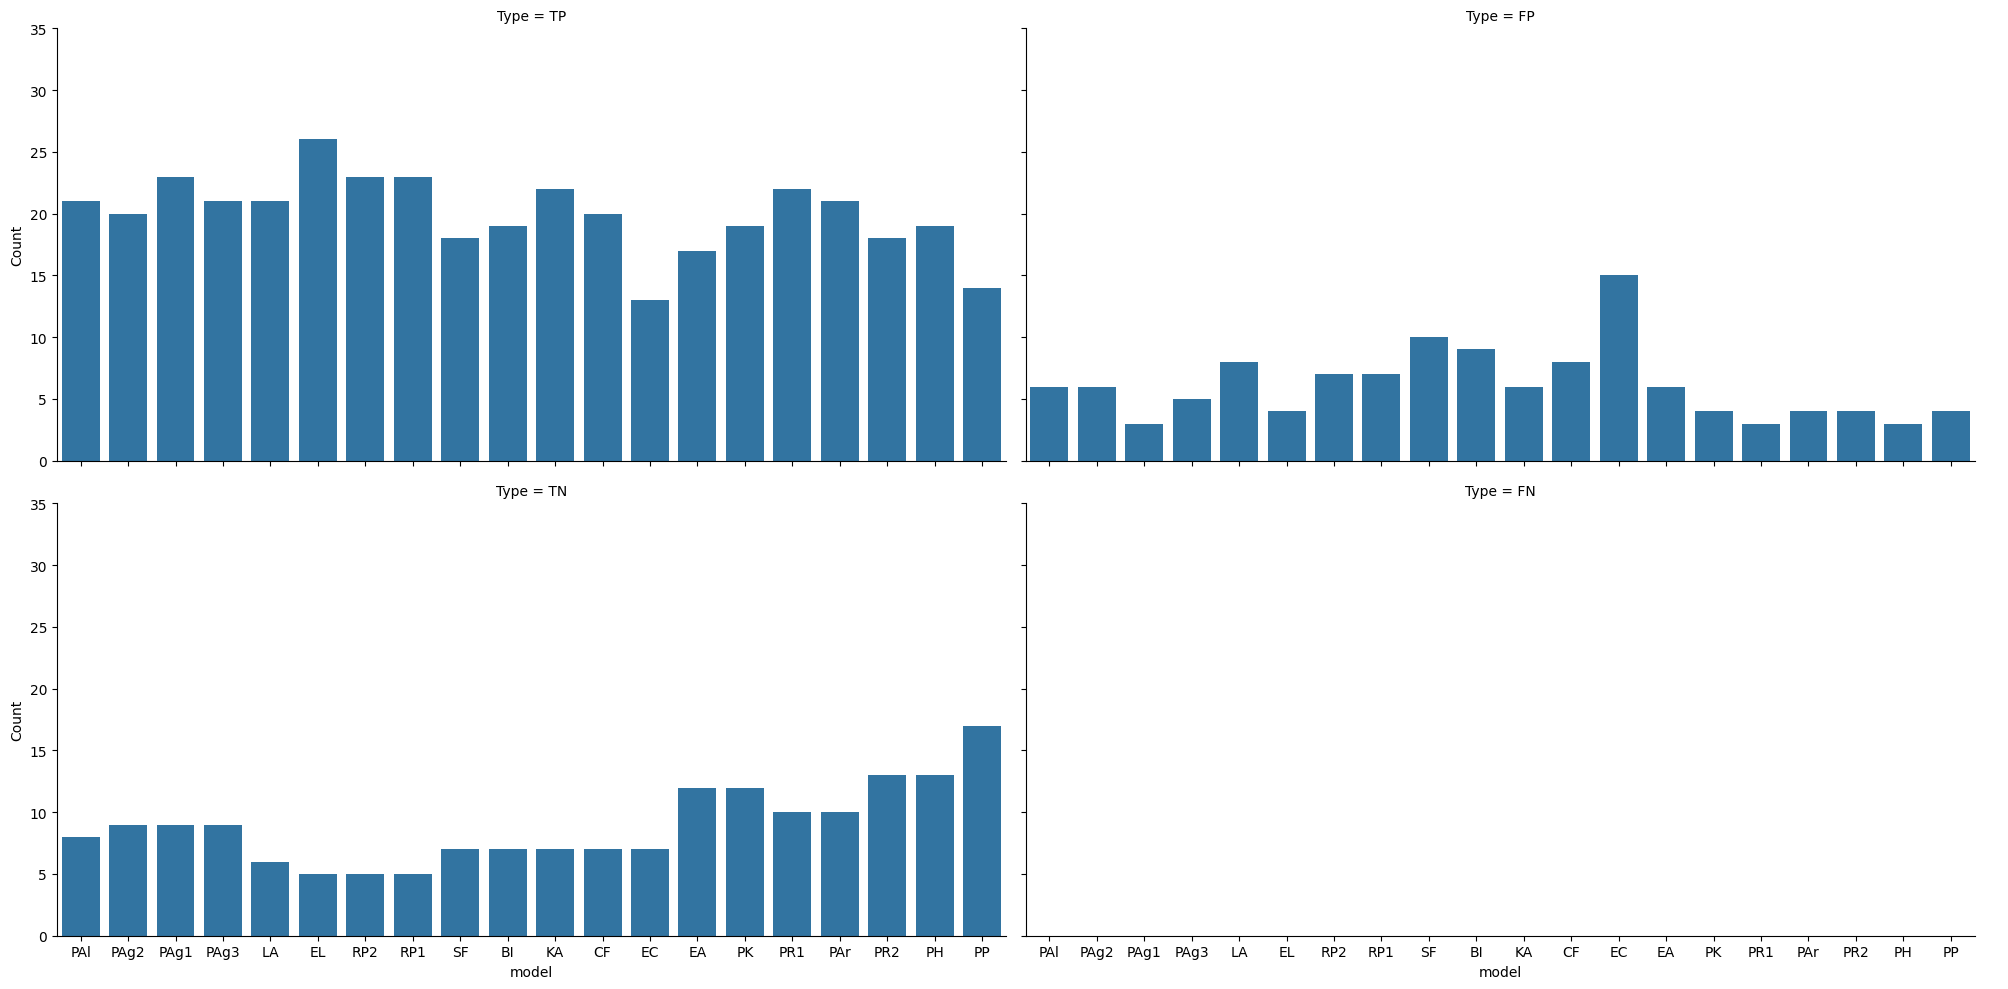

In [12]:
plot_confusion_matrix(pred_growth_binary, exp_yield_binary)

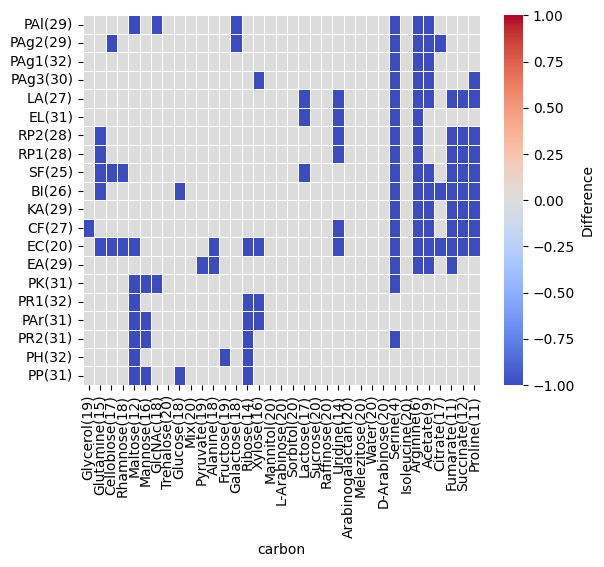

In [13]:
plot_diff_heatmap(pred_growth_binary, exp_yield_binary)

## Fix the models

### Find false positives

In [14]:
from kchip_utils import find_false_positives

In [15]:
false_positives = find_false_positives(pred_growth_binary, exp_yield_binary)

In [16]:
false_positives["PR1"]

['Maltose', 'Ribose', 'Xylose']

### Remove exchanges from the models for these false positives

In [17]:
new_model_dict = dict()
for model_name, model in model_dict.items():
    new_model = model.copy()
    for fp_media in false_positives[model_name]:
        for compounds_to_remove in carbon_sources[fp_media]:
            reaction = f"EX_{compounds_to_remove}_e0"
            new_model.remove_reactions(reaction)
    new_model_dict[model_name] = new_model

In [18]:
ec_model = model_dict["EC"]
ec_model_new = new_model_dict["EC"]

In [19]:
len(ec_model.reactions), len(ec_model_new.reactions)

(1848, 1833)

In [20]:
set(ec_model.medium.keys()) - set(ec_model_new.medium.keys())

{'EX_cpd00029_e0',
 'EX_cpd00035_e0',
 'EX_cpd00036_e0',
 'EX_cpd00051_e0',
 'EX_cpd00053_e0',
 'EX_cpd00054_e0',
 'EX_cpd00105_e0',
 'EX_cpd00106_e0',
 'EX_cpd00129_e0',
 'EX_cpd00137_e0',
 'EX_cpd00154_e0',
 'EX_cpd00158_e0',
 'EX_cpd00179_e0',
 'EX_cpd00249_e0',
 'EX_cpd00396_e0'}

### Simulate again and verify

In [21]:
fixed_pred_growth = simulate_predicted_growth(new_model_dict, media_dict, carbon_sources)
fixed_pred_growth_binary = fixed_pred_growth.map(lambda x: 1 if x > GROWTH_TRESHOLD else 0).astype(int)

Simulating EL in Succinate: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [04:12<00:00,  2.85it/s]


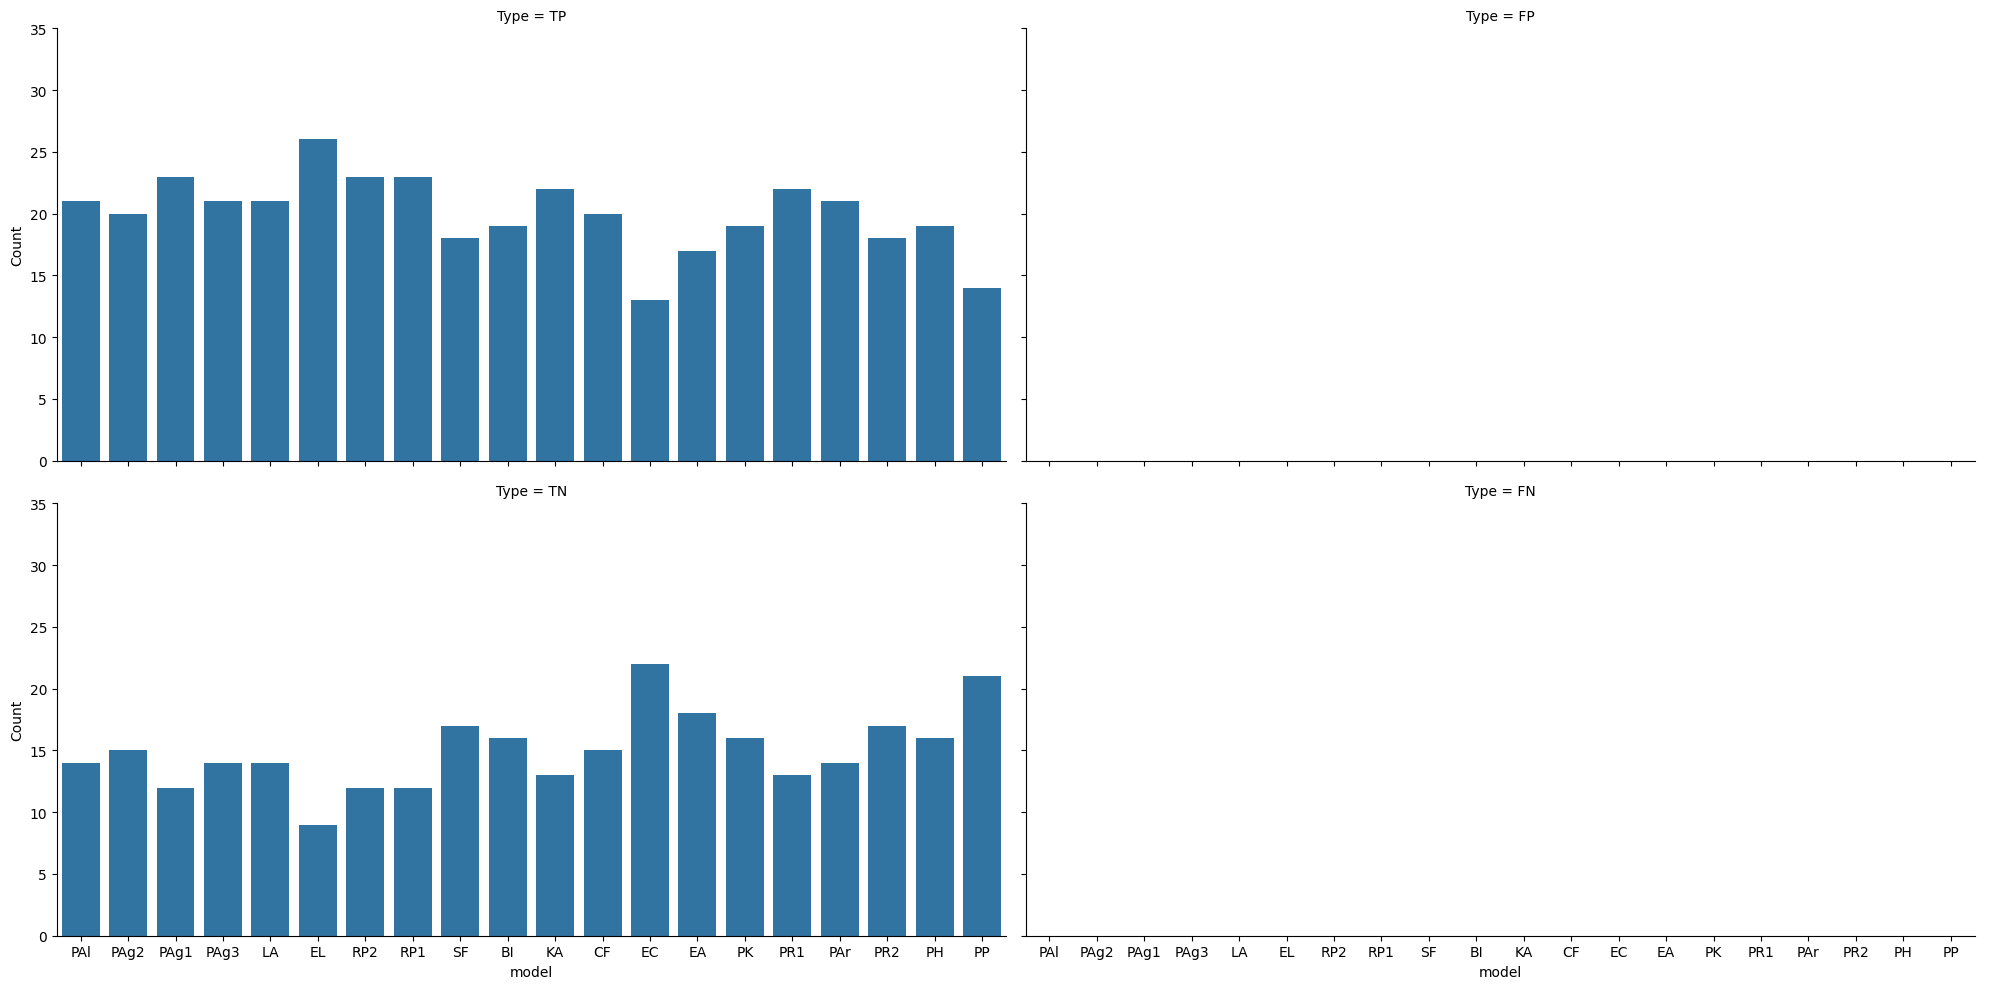

In [22]:
plot_confusion_matrix(fixed_pred_growth_binary, exp_yield_binary)

### Check the diff heatmap again

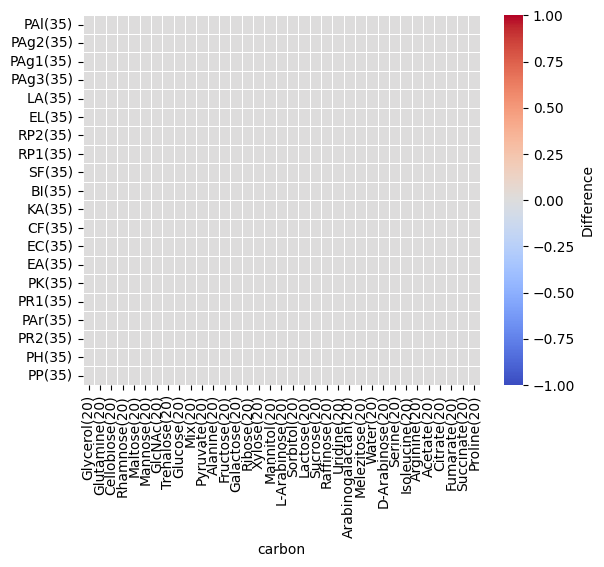

In [23]:
plot_diff_heatmap(fixed_pred_growth_binary, exp_yield_binary)

In [24]:
from cobra.io import write_sbml_model

In [25]:
output_dir = pathlib.Path("../../data/processed/kchip/models_fixed/")
for model_name, model in new_model_dict.items():
    file_name = output_dir / f"{model_name}.genome.mdl.sbml"
    if not file_name.exists():
        write_sbml_model(model, file_name)

In [26]:
fixed_pred_growth[fixed_pred_growth > 0].min(axis=1)

model
PAl     0.030343
PAg2    0.029631
PAg1    0.029630
PAg3    0.047642
LA      0.033959
EL      0.015381
RP2     0.017908
RP1     0.017908
SF      0.038958
BI      0.053099
KA      0.044751
CF      0.052426
EC      0.064919
EA      0.063836
PK      0.082144
PR1     0.056165
PAr     0.041743
PR2     0.035797
PH      0.047296
PP      0.078912
dtype: float64

## Find correlation between experimental yield and predicted growth

In [27]:
from kchip_utils import _match_data

In [28]:
pred_data, exp_data = _match_data(
    pred_data_raw=fixed_pred_growth, exp_data_raw=exp_yield)
exp_arr = exp_data.values.ravel()
pred_arr = pred_data.values.ravel()

In [29]:
from scipy import stats

In [30]:
stats.pearsonr(pred_arr, exp_arr)

PearsonRResult(statistic=0.39575575033494875, pvalue=1.1503014857901451e-27)

In [31]:
stats.spearmanr(pred_arr, exp_arr)

SignificanceResult(statistic=0.7666723626720013, pvalue=1.872665701722989e-136)

We have a good spearman correlation!

## Save the results for machine learning

In [1]:
import pathlib

import warnings
import logging

warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.ERROR)

In [2]:
from cobra.io import read_sbml_model

In [3]:
from kchip_utils import _match_data, read_experimental_yield, simulate_predicted_growth, load_models_and_media

In [4]:
models_folder = pathlib.Path("../../data/processed/kchip/models_fixed")
media_folder = pathlib.Path("../../data/processed/kchip/media")
model_dict, media_dict = load_models_and_media(models_folder, media_folder)

'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.


In [5]:
CSOURCE_ID = 17
carbon_sources = dict(sorted({k: v[CSOURCE_ID:] for k, v in media_dict.items()}.items()))

In [6]:
met_profile_file = pathlib.Path("../../data/raw/kchip/media/metabolic_profiles.csv")
exp_yield = read_experimental_yield(met_profile_file, normalize=False)
fixed_pred_growth = simulate_predicted_growth(model_dict, media_dict, carbon_sources, normalize=False)

Simulating EL in Succinate: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [04:28<00:00,  2.68it/s]


In [7]:
pred_data, exp_data = _match_data(pred_data_raw=fixed_pred_growth, exp_data_raw=exp_yield)

In [9]:
growth_data_file = pathlib.Path("../../data/processed/kchip/monoculture_yield_growth.csv")
with open(growth_data_file, "w") as fid:
    fid.write("index,carbon,exp_yield,pred_growth")
    for row_id in exp_data.index:
        for col_id in exp_data.columns:
            exp_data_item = exp_data.loc[row_id, col_id]
            pred_data_item = pred_data.loc[row_id, col_id]
            fid.write(f"{row_id},{col_id},{exp_data_item},{pred_data_item}")
            fid.write("\n")